### Order of productions on each station or feature

Randomly pick one column `L3_S50_D4252`

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 
import tqdm
import os
from matplotlib.backends.backend_pdf import PdfPages

% matplotlib inline

In [2]:
# Obtain all labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])
df = pd.read_csv('data/train_date.csv.zip', index_col=0)
df = df.join(response)

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
del response
gc.collect()

n_parts, n_columns = df.shape
n_columns -= 1
print(n_parts, n_columns)

1183747 1156


In [4]:
# stations and features in each station
stations = list(set([f.split('_')[1] for f in df.columns.tolist() if f!='Response']))

station_features = {s: [f for f in df.columns.tolist() if s in f] for s in stations }

In [108]:
# Calculate samples in each feature, if there is any station that every or almost every part flows by?
columns = df.columns.tolist()
feature_samples = {}
for col in tqdm.tqdm_notebook(columns):
    feature_samples[col] = len(df.loc[df[col].notna(), col])

feature_samples = pd.Series(feature_samples)
feature_samples.sort_values(ascending=False, inplace=True)
feature_samples.drop('Response', inplace=True)

feature_samples = feature_samples.reset_index()
feature_samples.columns = ['feature', 'count']
fs = feature_samples.copy()
fs['station'] = feature_samples['feature'].apply(lambda x: x.split('_')[1])

station_samples = fs.groupby('station')['count'].max().sort_values(ascending=False)

In [13]:
station_time = {}
for s in tqdm.tqdm_notebook(stations):
    station_time[s+'_start'] = df[station_features[s]].min(axis=1)
    station_time[s+'_end'] = df[station_features[s]].max(axis=1)
    station_time[s+'_duration'] = station_time[s+'_end'] - station_time[s+'_start']

In [176]:
# Remove the end time and duration for stations whose start and end times are identical for most parts 
x = pd.DataFrame(station_time)
x = x.join(df.Response)
    
# features will be categorized
cols = [n.format(i) for i in range(52) for n in ['S{}_start', 'S{}_end', 'S{}_duration'] ]
don = [] # features will not be categorized because they are redundant or have too few samples
    
# filter columns
for f in tqdm.tqdm_notebook(cols):
    if f=='Response':
        continue
    bins = int(max(10, station_samples[f.split('_')[0]]/20000))
    x[f] = pd.qcut(x[f], bins, labels=False, duplicates='drop')
    if (len(x[f].unique())==1) | (station_samples[f.split('_')[0]]<20):
        don.append(f)
        continue

don.extend([u.split('_')[0]+'_end' for u in don if u.split('_')[1]=='duration'])
cols = [u for u in cols if u not in don]

if os.path.isfile('station_time.pdf'):
    os.remove('station_time.pdf')

with PdfPages('station_time.pdf') as pp:
    for f in tqdm.tqdm_notebook(cols):
        a = x.groupby(f).Response.agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
        a['confidence_interval'] = 1.96 * np.sqrt(a['mean'] * (1-a['mean']) / a['count'])
        a['mean_low'] = a['mean'] - a['confidence_interval']
        a['mean_high'] = a['mean'] + a['confidence_interval']

        fig = plt.figure(figsize=(14, 7))
        bars = plt.bar(a.index, a['mean'], yerr=a['confidence_interval'], label='error rate per bin')
        line = plt.plot([-1, len(a)], [0.0058, 0.0058], color='tab:red', label='average error rate')
        plt.title('$P(error \mid$ {})'.format(f))
        plt.xlabel('{}'.format(f), fontsize=16)
        plt.close(fig)
        pp.savefig(fig)


In [ ]:
x.drop(don, axis=1, inplace=True)

x.to_csv('station_time.csv', index=True)

### Two methods calculating confidence interval of binomial distribution
To obtain statistically significant results, it's good to not only check
For large sample size, they are the same.

In [145]:
wald = lambda p, n: 1.96 * np.sqrt(p*(1-p)/n)
wald(0.01, 5000)

0.0027579644667761766

In [128]:
def agresti(p, n):
    n1 = p * n
    pt = (n1 + 0.5 * 1.96**2) / (n + 1.96**2)
    return 1.96 * np.sqrt(pt * (1-pt) / (n + 1.96**2))
agresti(0.006, 10000)

0.0015369484116397646

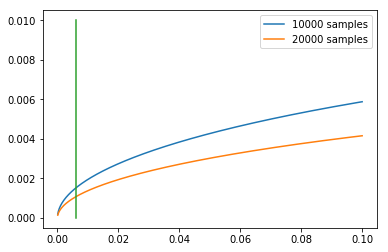

In [141]:
p = np.arange(0.0001, .1, 0.0001)
e1 = [wald(i, 10000) for i in p]
e2 = [wald(i, 20000) for i in p]
plt.plot(p, e1, label='10000 samples')
plt.plot(p, e2, label='20000 samples')
plt.plot([0.006, 0.006], [0, .01])
plt.legend()
plt.show()